<a href="https://colab.research.google.com/github/BasselShaheen06/Anatomy_Projects/blob/master/tutorials/W1D4_DimensionalityReduction/student/W1D4_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4:  Nonlinear Dimensionality Reduction

**Week 1, Day 4: Dimensionality Reduction**

**By Neuromatch Academy**

**Content creators:** Alex Cayco Gajic, John Murray

**Content reviewers:** Roozbeh Farhoudi, Matt Krause, Spiros Chavlis, Richard Gao, Michael Waskom, Siddharth Suresh, Natalie Schaworonkow, Ella Batty

**Production editors:** Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 35 minutes*

In this notebook we'll explore how dimensionality reduction can be useful for visualizing and inferring structure in your data. To do this, we will compare PCA with t-SNE, a nonlinear dimensionality reduction method.

Overview:
- Visualize MNIST in 2D using PCA.
- Visualize MNIST in 2D using t-SNE.

In [1]:

# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "kaq2x"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/kaq2x/


---
# Setup


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D4_T4"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting Functions

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  plt.scatter(x=component1, y=component2, c=labels, cmap='tab10')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

---
# Section 0: Intro to applications

In [6]:
# @title Video 1: PCA Applications
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '2Zb93aOWioM'), ('Bilibili', 'BV1Jf4y1R7UZ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [7]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_PCA_Applications_Video")

---
# Section 1: Visualize MNIST in 2D using PCA

In this exercise, we'll visualize the first few components of the MNIST dataset to look for evidence of structure in the data. But in this tutorial, we will also be interested in the label of each image (i.e., which numeral it is from 0 to 9). Start by running the following cell to reload the MNIST dataset (this takes a few seconds).

In [8]:
from sklearn.datasets import fetch_openml

# Get images
mnist = fetch_openml(name='mnist_784', as_frame=False, parser='auto')
X_all = mnist.data

# Get labels
labels_all = np.array([int(k) for k in mnist.target])

**Note:** We saved the complete dataset as `X_all` and the labels as `labels_all`.

To perform PCA, we now will use the method implemented in sklearn. Run the following cell to set the parameters of PCA - we will only look at the top 2 components because we will be visualizing the data in 2D.

In [9]:
from sklearn.decomposition import PCA

# Initializes PCA
pca_model = PCA(n_components=2)

# Performs PCA
pca_model.fit(X_all)

PCA(n_components=2)

## Coding Exercise 1: Visualization of MNIST in 2D using PCA

Fill in the code below to perform PCA and visualize the top two  components. For better visualization, take only the first 2,000 samples of the data (this will also make t-SNE much faster in the following section of the tutorial so don't skip this step!)

**Suggestions:**
- Truncate the data matrix at 2,000 samples. You will also need to truncate the array of labels.
- Perform PCA on the truncated data.
- Use the function `visualize_components` to plot the labeled data.

In [10]:
help(visualize_components)
help(pca_model.transform)

Help on function visualize_components in module __main__:

visualize_components(component1, component2, labels, show=True)
    Plots a 2D representation of the data for visualization with categories
    labelled as different colors.
    
    Args:
      component1 (numpy array of floats) : Vector of component 1 scores
      component2 (numpy array of floats) : Vector of component 2 scores
      labels (numpy array of floats)     : Vector corresponding to categories of
                                           samples
    
    Returns:
      Nothing.

Help on method transform in module sklearn.decomposition._base:

transform(X) method of sklearn.decomposition._pca.PCA instance
    Apply dimensionality reduction to X.
    
    X is projected on the first principal components previously extracted
    from a training set.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        New data, where `n_samples` is the number of samples
    

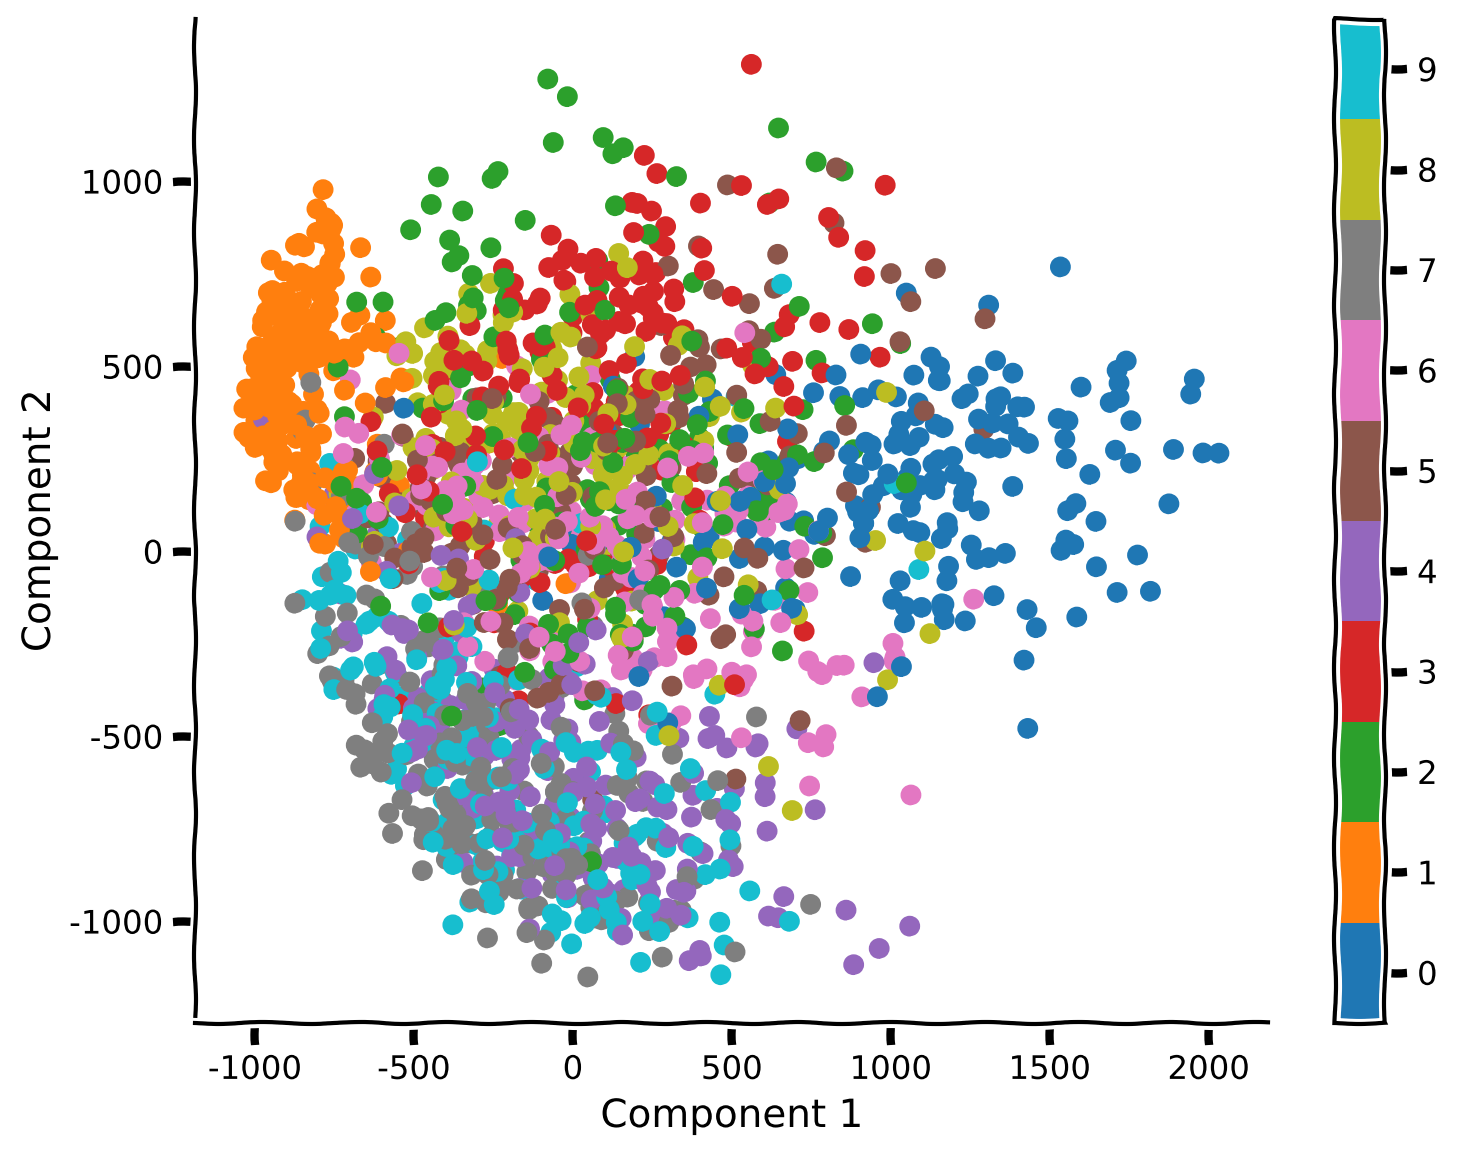

In [13]:
################################################
## TODO for students: take only 2,000 samples and perform PCA
# Comment once you've completed the code
# raise NotImplementedError("Student exercise: perform PCA")
#################################################

# Take only the first 2000 samples with the corresponding labels
X, labels = X_all[:2000, :], labels_all[:2000]

# Perform PCA
scores = pca_model.transform(X)

# Plot the data and reconstruction
with plt.xkcd():
  visualize_components(scores[:, 0], scores[:, 1], labels)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D4_DimensionalityReduction/solutions/W1D4_Tutorial4_Solution_58cf80ab.py)

*Example output:*

<img alt='Solution hint' align='left' width=728.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial4_Solution_58cf80ab_0.png>



In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Visualization_of_MNIST_in_2D_using_PCA_Exercise")

## Think! 1: PCA Visualization

1.  What do you see? Are different samples corresponding to the same numeral clustered together? Is there much overlap?
2.  Do some pairs of numerals appear to be more distinguishable than others?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D4_DimensionalityReduction/solutions/W1D4_Tutorial4_Solution_c2749fdf.py)



In [15]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_PCA_Visualization_Discussion")

---
# Section 2: Visualize MNIST in 2D using t-SNE

*Estimated timing to here from start of tutorial: 15 min*


In [16]:
# @title Video 2: Nonlinear Methods
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '5Xpb0YaN5Ms'), ('Bilibili', 'BV14Z4y1u7HG')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [17]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Nonlinear_methods_Video")

Next we will analyze the same data using t-SNE, a nonlinear dimensionality reduction method that is useful for visualizing high dimensional data in 2D or 3D. Run the cell below to get started.

In [18]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

## Coding Exercise 2.1: Apply t-SNE on MNIST
First, we'll run t-SNE on the data to explore whether we can see more structure. The cell above defined the parameters that we will use to find our embedding (i.e, the low-dimensional representation of the data) and stored them in `model`. To run t-SNE on our data, use the function `model.fit_transform`.

**Suggestions:**
- Run t-SNE using the function `model.fit_transform`.
- Plot the result data using `visualize_components`.

In [19]:
help(tsne_model.fit_transform)

Help on method fit_transform in module sklearn.manifold._t_sne:

fit_transform(X, y=None) method of sklearn.manifold._t_sne.TSNE instance
    Fit X into an embedded space and return that transformed output.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features) or             (n_samples, n_samples)
        If the metric is 'precomputed' X must be a square distance
        matrix. Otherwise it contains a sample per row. If the method
        is 'exact', X may be a sparse matrix of type 'csr', 'csc'
        or 'coo'. If the method is 'barnes_hut' and the metric is
        'precomputed', X may be a precomputed sparse graph.
    
    y : None
        Ignored.
    
    Returns
    -------
    X_new : ndarray of shape (n_samples, n_components)
        Embedding of the training data in low-dimensional space.



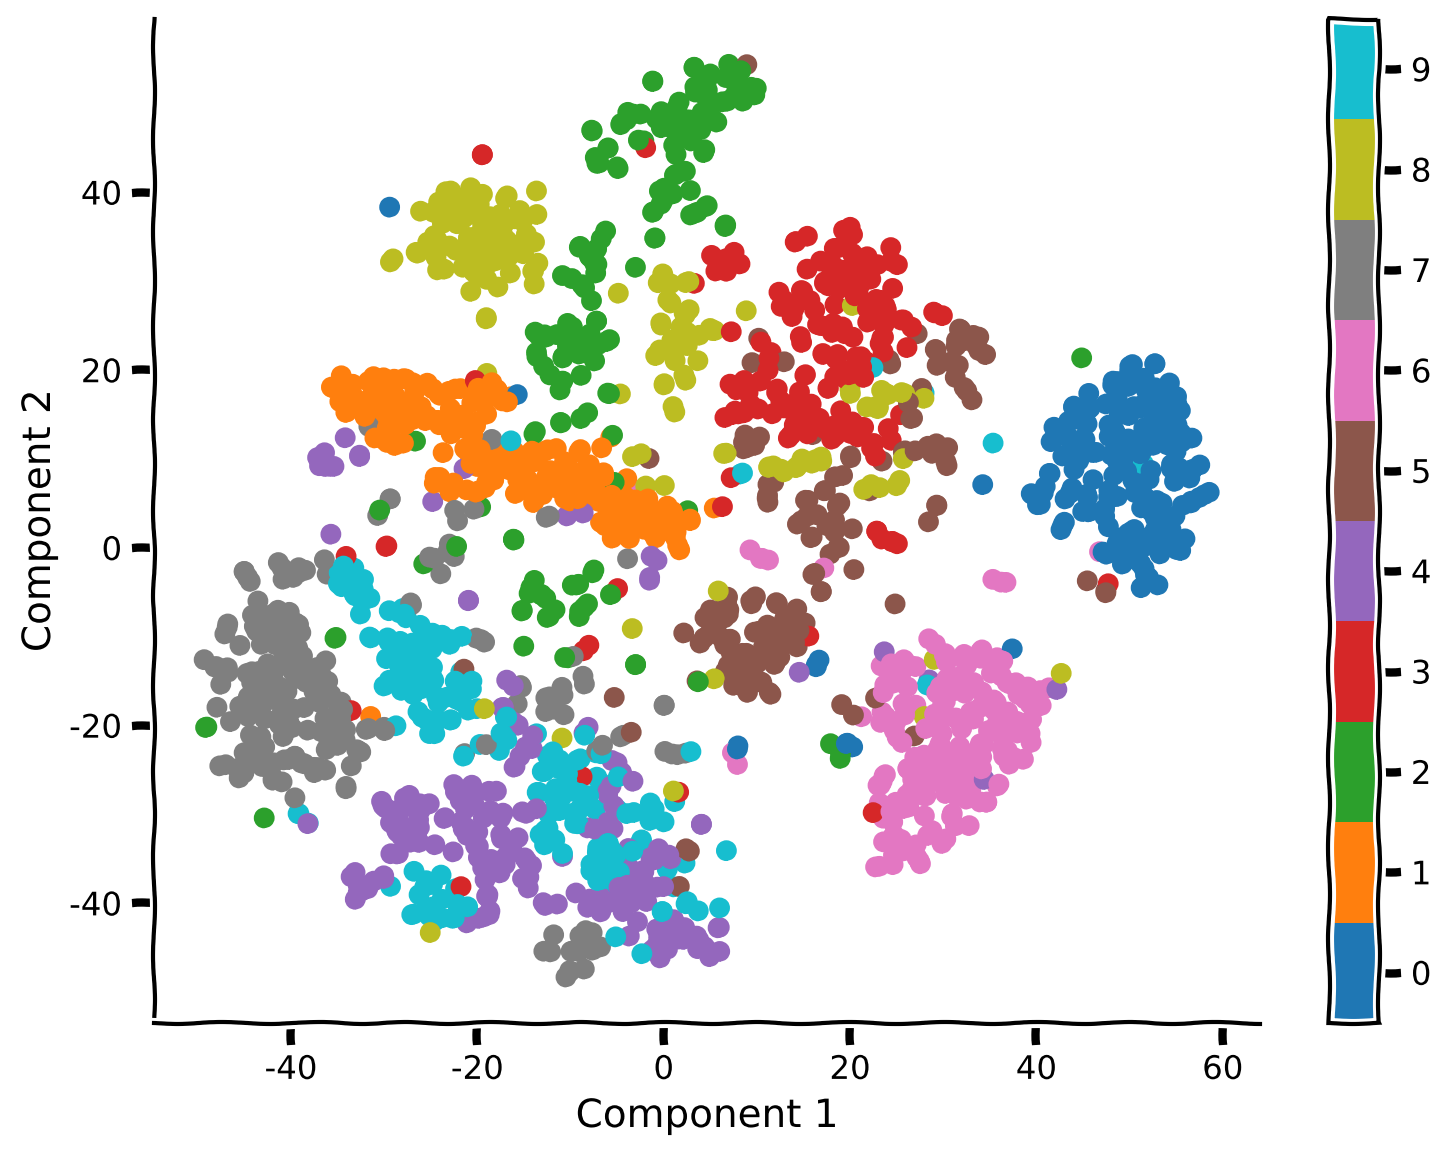

In [20]:
#################################################
## TODO for students
# Comment once you've completed the code
# raise NotImplementedError("Student exercise: perform t-SNE")
#################################################

# Perform t-SNE
embed = tsne_model.fit_transform(X)

# Visualize the data
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1], labels)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D4_DimensionalityReduction/solutions/W1D4_Tutorial4_Solution_4e6f6604.py)

*Example output:*

<img alt='Solution hint' align='left' width=725.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial4_Solution_4e6f6604_0.png>



In [21]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Apply_tSNE_on_MNIST_Exercise")

## Coding Exercise 2.2: Run t-SNE with different perplexities

Unlike PCA, t-SNE has a free parameter (the perplexity) that roughly determines how global vs. local information is weighted. Here we'll take a look at how the perplexity affects our interpretation of the results.

**Steps:**
- Rerun t-SNE (don't forget to re-initialize using the function `TSNE` as above) with a perplexity of 50, 5 and 2.

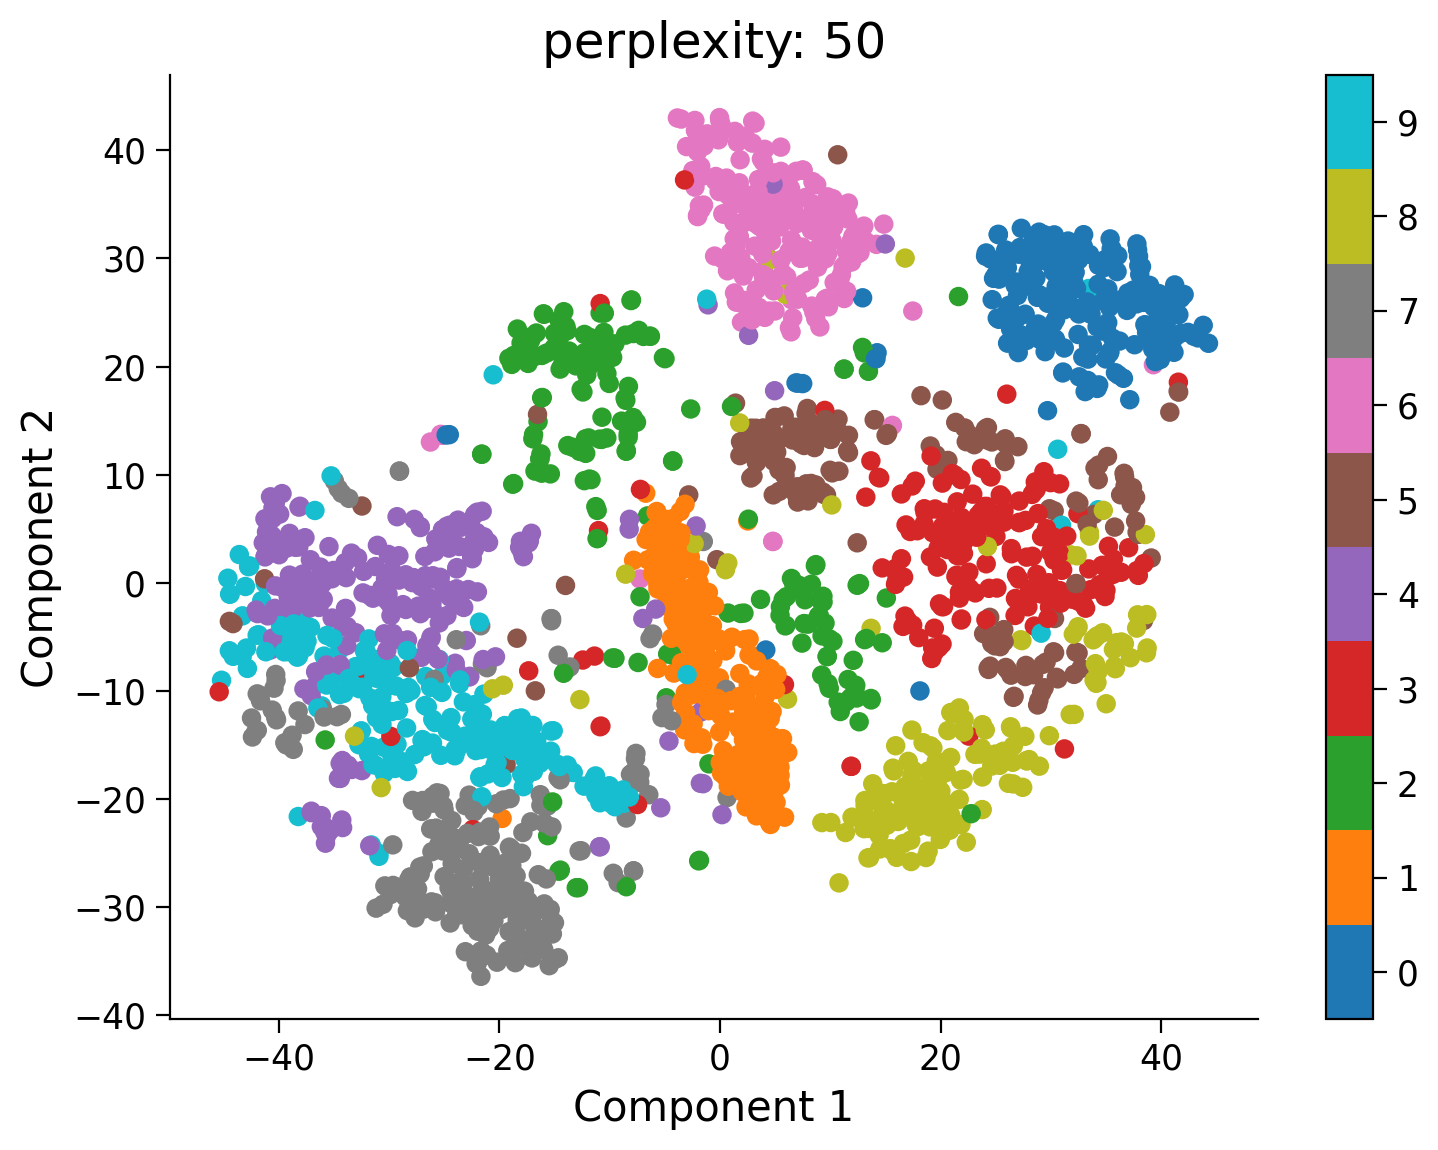

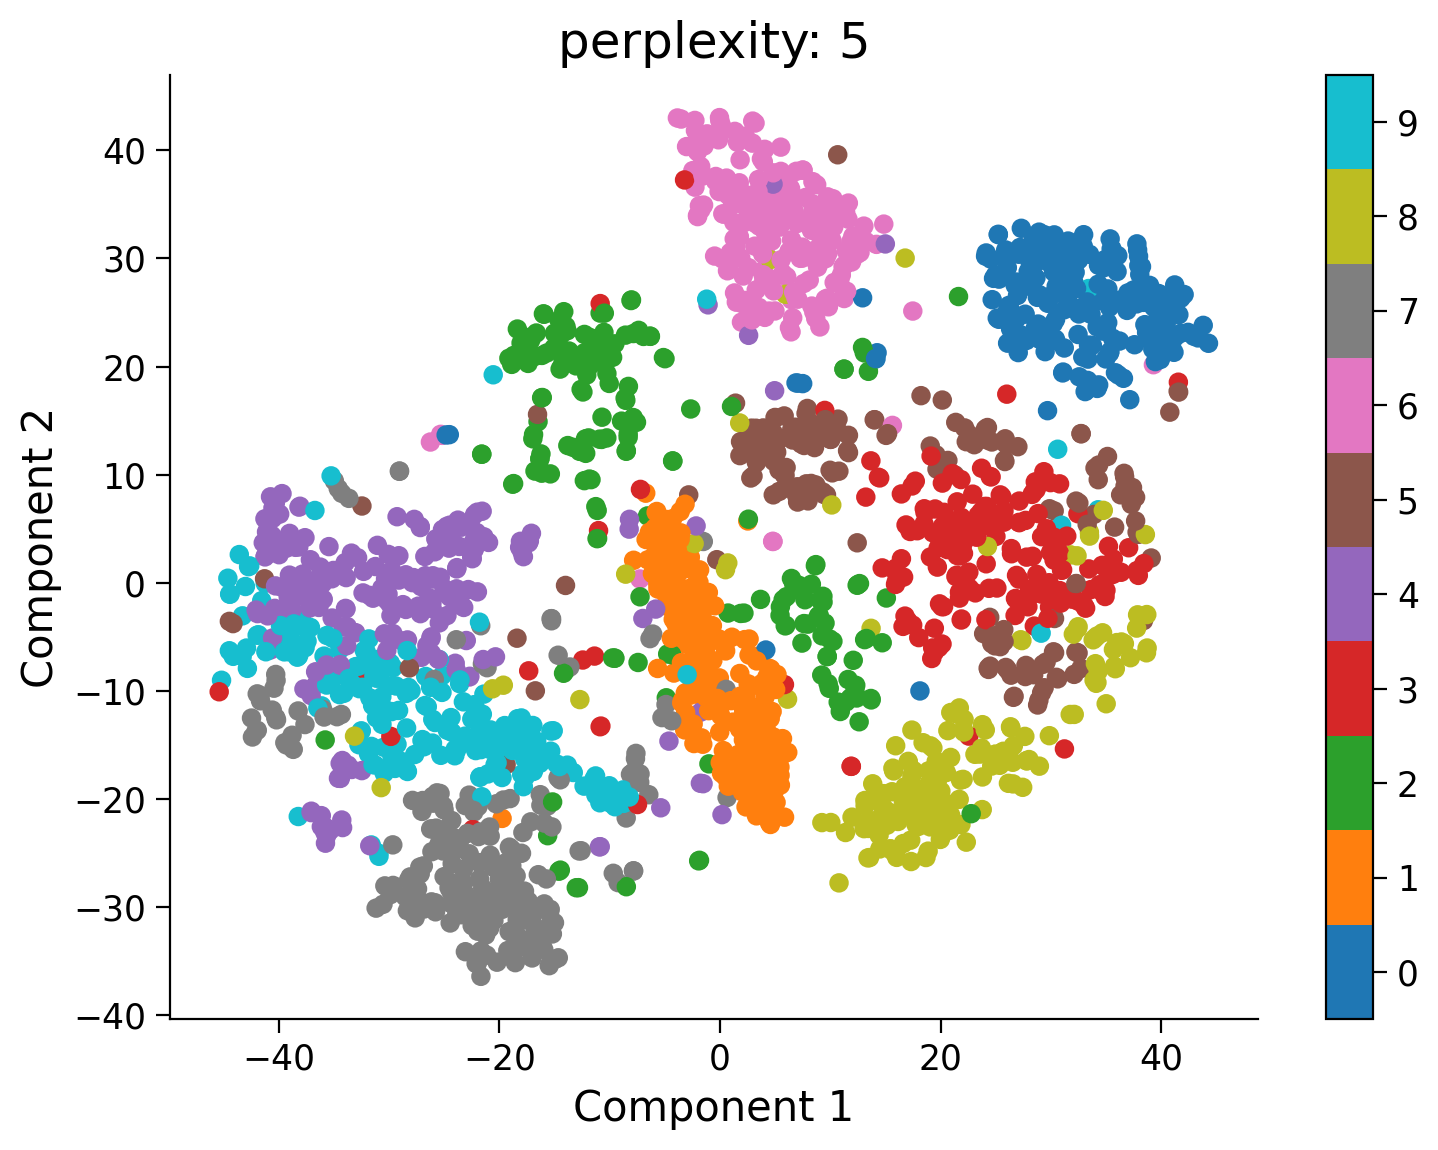

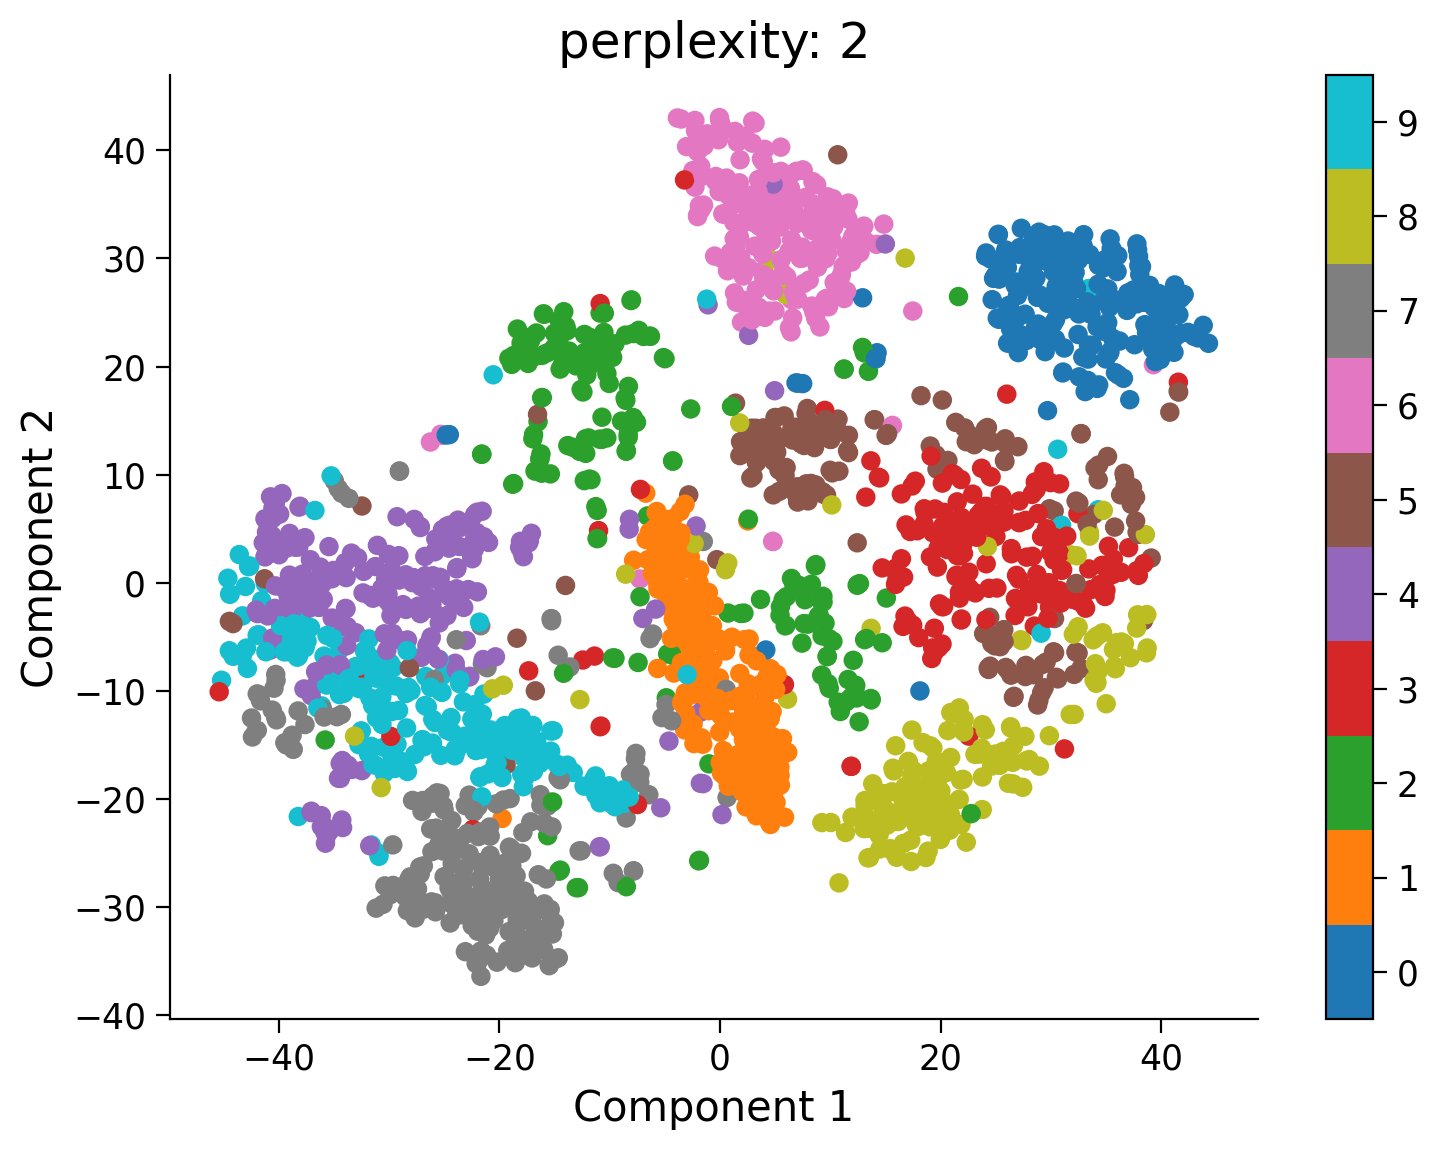

In [23]:
def explore_perplexity(values, X, labels):
  """
  Plots a 2D representation of the data for visualization with categories
  labeled as different colors using different perplexities.

  Args:
    values (list of floats) : list with perplexities to be visualized
    X (np.ndarray of floats) : matrix with the dataset
    labels (np.ndarray of int) : array with the labels

  Returns:
    Nothing.

  """
  for perp in values:

    #################################################
    ## TO DO for students: Insert your code here to redefine the t-SNE "model"
    ## while setting the perplexity perform t-SNE on the data and plot the
    ## results for perplexity = 50, 5, and 2 (set random_state to 2020
    # Comment these lines when you complete the function
    # raise NotImplementedError("Student Exercise! Explore t-SNE with different perplexity")
    #################################################

    # Perform t-SNE
    tsne_model = TSNE(n_components=2, perplexity=50, random_state=2020)

    embed = tsne_model.fit_transform(X)
    visualize_components(embed[:, 0], embed[:, 1], labels, show=False)
    plt.title(f"perplexity: {perp}")


# Visualize
values = [50, 5, 2]
explore_perplexity(values, X, labels)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D4_DimensionalityReduction/solutions/W1D4_Tutorial4_Solution_2e8ff78c.py)

*Example output:*

<img alt='Solution hint' align='left' width=724.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial4_Solution_2e8ff78c_0.png>

<img alt='Solution hint' align='left' width=724.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial4_Solution_2e8ff78c_1.png>

<img alt='Solution hint' align='left' width=726.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D4_DimensionalityReduction/static/W1D4_Tutorial4_Solution_2e8ff78c_2.png>



In [24]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Run_tSNE_with_different_perplexities_Exercise")

## Think! 2: t-SNE Visualization

1. What changed compared to your previous results using perplexity equal to 50? Do you see any clusters that have a different structure than before?
2. What changed in the embedding structure for perplexity equals to 5 or 2?

In [25]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_tSNE_Visualization_Discussion")

---
# Summary

*Estimated timing of tutorial: 35 minutes*

* We learned the difference between linear and nonlinear dimensionality reduction. While nonlinear methods can be more powerful, they can also be sensitive to noise. In contrast, linear methods are useful for their simplicity and robustness.
* We compared PCA and t-SNE for data visualization. Using t-SNE, we could visualize clusters in the data corresponding to different digits. While PCA was able to separate some clusters (e.g., 0 vs 1), it performed poorly overall.
* However, the results of t-SNE can change depending on the choice of perplexity. To learn more, we recommend this Distill paper by [Wattenberg, _et al._, 2016](http://doi.org/10.23915/distill.00002).
